In [1]:
%matplotlib inline

In [2]:
import numpy as np
import xarray as xr
import pandas as pd

import scipy.spatial
import scipy.linalg

import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

import plotly.plotly as py
import plotly.graph_objs as go

from ipywidgets import *

In [3]:
import rpy2.robjects as robjs
from rpy2.robjects.packages import importr
import statsmodels.api as sm
from IPython.display import display
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [4]:
# Import R packages in Python
r = robjs.r
nlme = importr('nlme')
stats = importr('stats')
gstat = importr('gstat')  # Create symlink from anaconda envs tcl to ./lib/tcl
sp = importr('sp')

In [5]:
# Load the data
# wget ftp://sidads.colorado.edu/pub/DATASETS/NOAA/G10010/G10010_SIBT1850_v1.1.zip
nc = xr.open_dataset('data/G10010_SIBT1850_v1.1.nc')

In [7]:
# Average out years
yr_avg = nc.seaice_conc.groupby('time.year').mean()

# Separate into seasons
seasons = nc.seaice_conc.groupby('time.season').mean('latitude').mean('longitude')
seas_df = seasons.to_dataframe()
seas_df = seas_df.groupby([lambda x: x.year, 'season']).mean()
seas_df = seas_df.reset_index()

djf_df = seas_df.loc[seas_df['season'] == 'DJF']
jja_df = seas_df.loc[seas_df['season'] == 'JJA']
mam_df = seas_df.loc[seas_df['season'] == 'MAM']
son_df = seas_df.loc[seas_df['season'] == 'SON']

In [8]:
y = yr_avg.values
t1 = yr_avg.year.values

# Piecewise linear regression

### Estimate $\tau$  and fit a seperate regression model


(1). $\tau \in \mathrm{T}$

(2). $\forall \tau \in \mathrm{T}$ fit a sperate regression model

In [9]:
# Initialize fixed set of possible Breakpoints.
T = np.array([1950, 1960, 1970, 1975, 1978, 1979,
              1980, 1985, 1990, 1995, 2000])

In [10]:
# Series split before tau
t_tau_pre = [t1[t1<=tau] for tau in T]
y_tau_pre = [y[t1<=tau] for tau in T]

# Series split after tau
t_tau_post = [t1[t1>tau] for tau in T]
y_tau_post = [y[t1>tau] for tau in T]

In [11]:
# Estimates for pre tau
betahat_pre = []
mse_pre = []
for t_tau, y_tau in zip(t_tau_pre, y_tau_pre):
    robjs.globalenv['y_tau'] = robjs.FloatVector(y_tau)
    robjs.globalenv['t_tau'] = robjs.FloatVector(t_tau)
    fit_tau = r.lm('y_tau ~ t_tau')
    e = fit_tau.rx2('residuals')
    betahat_pre.append(fit_tau.rx2('coefficients'))
    mse_pre.append(np.mean(np.square(np.array(e))))

In [12]:
# Estimates for post tau
betahat_post = []
mse_post = []
for t_tau, y_tau in zip(t_tau_post, y_tau_post):
    robjs.globalenv['y_tau'] = robjs.FloatVector(y_tau)
    robjs.globalenv['t_tau'] = robjs.FloatVector(t_tau)
    fit_tau = r.lm('y_tau ~ t_tau')
    e = fit_tau.rx2('residuals')
    betahat_post.append(fit_tau.rx2('coefficients'))
    mse_post.append(np.mean(np.square(np.array(e))))

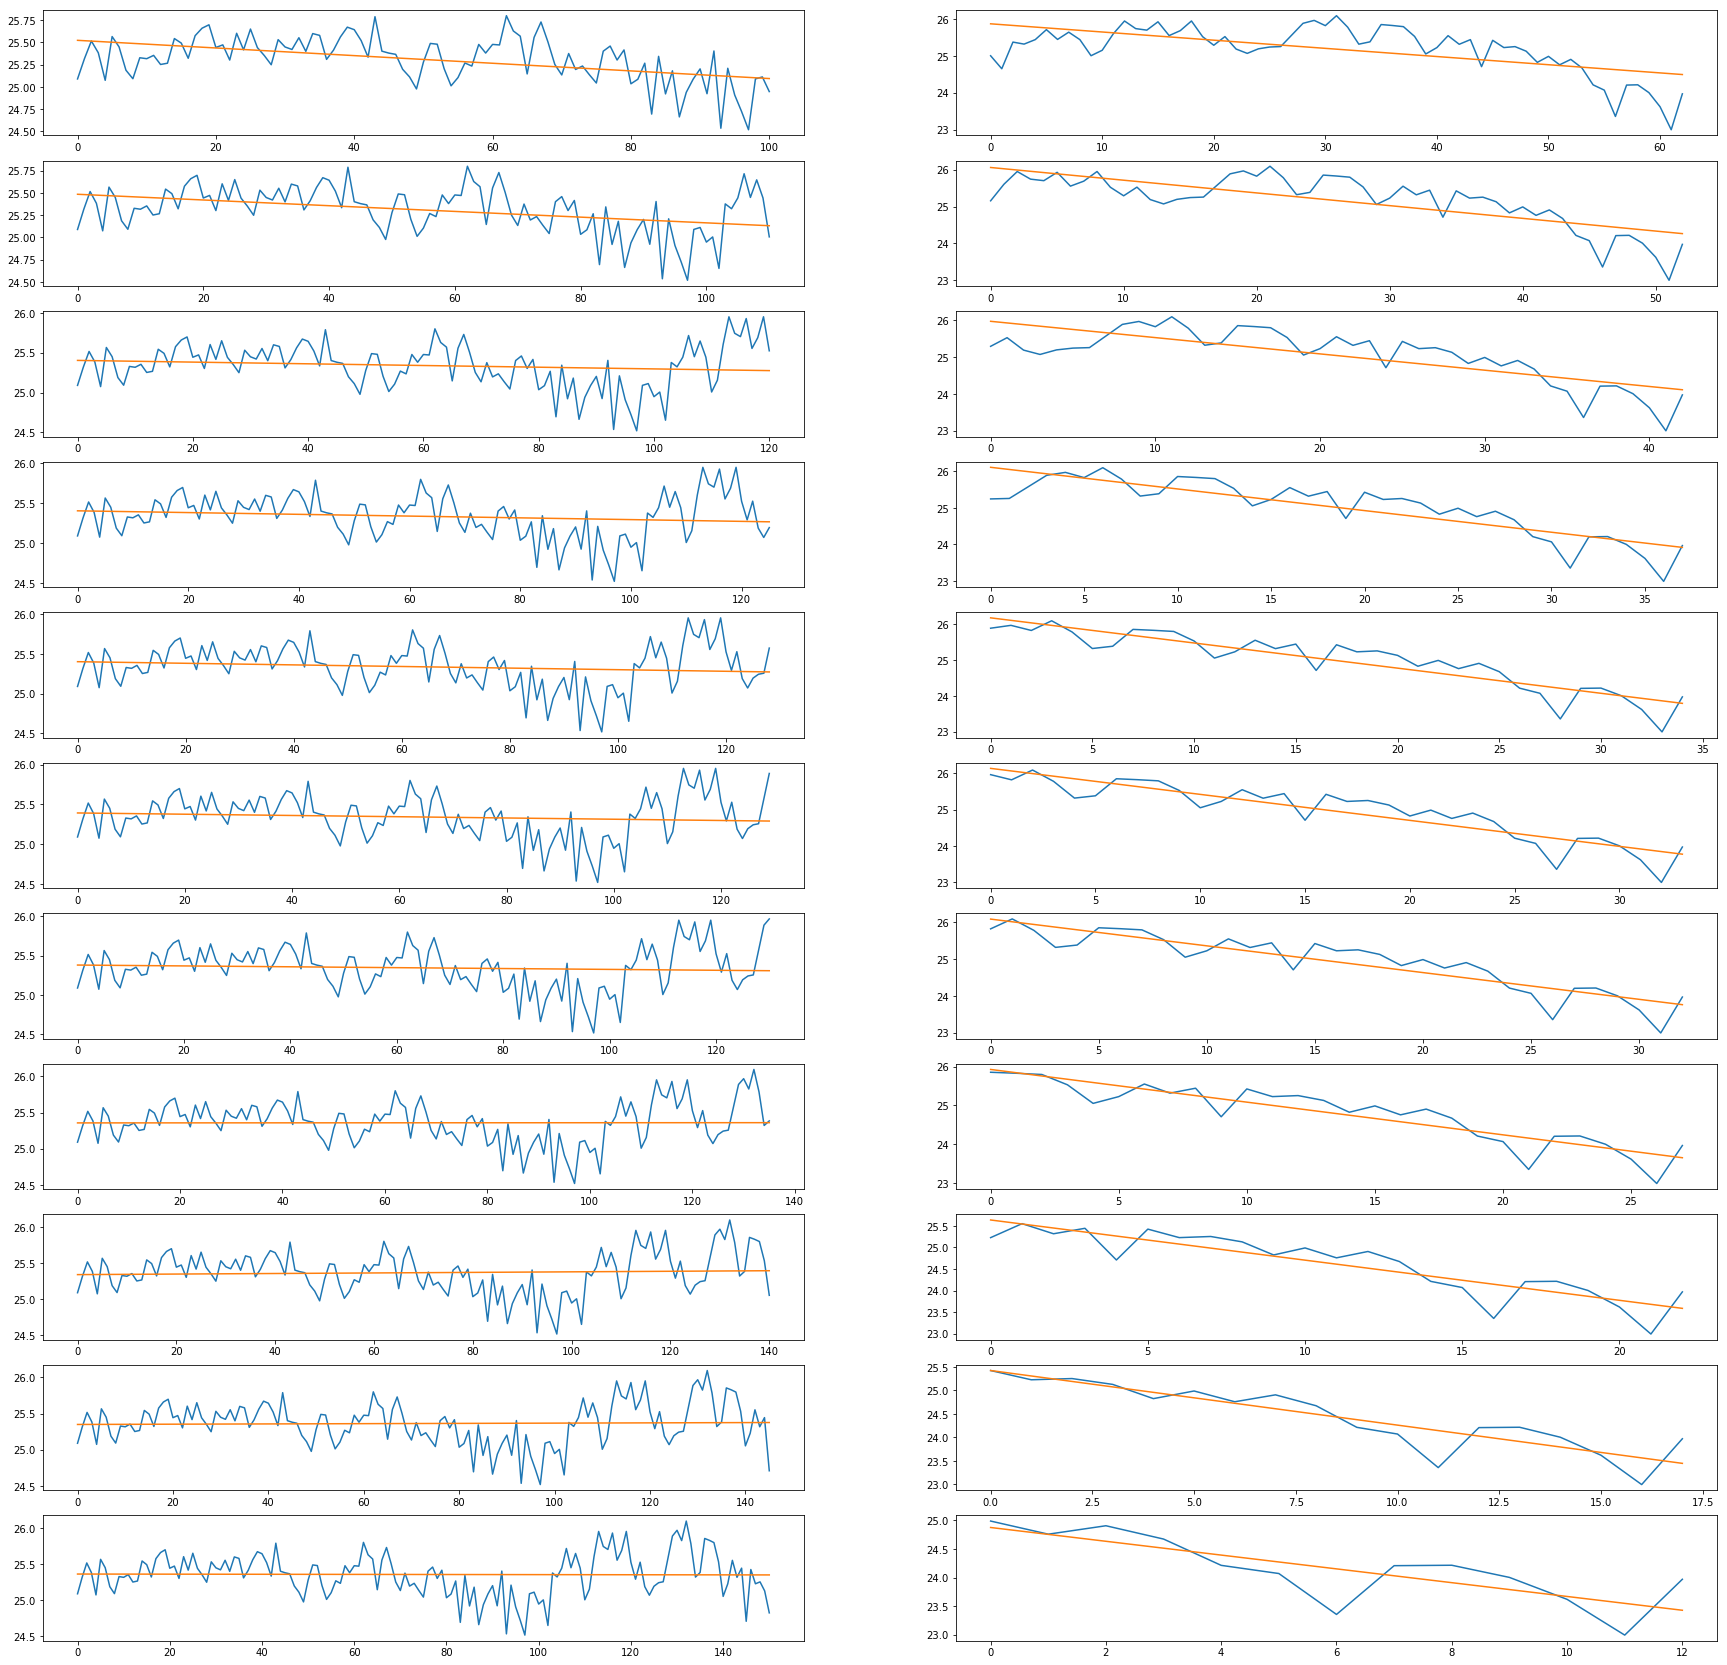

In [13]:
# Plot all the pre and posts regressions
regressions_pre = [beta[0] + beta[1]*t_tau_pre[t] for t, beta in enumerate(betahat_pre)]
regressions_post = [beta[0] + beta[1]*t_tau_post[t] for t, beta in enumerate(betahat_post)]

nrows = len(T)
fig, axs = plt.subplots(nrows, 2, figsize=(30, 30))
for i, row in enumerate(axs):
    row[0].plot(y_tau_pre[i])
    row[0].plot(regressions_pre[i])
    row[1].plot(y_tau_post[i])
    row[1].plot(regressions_post[i])

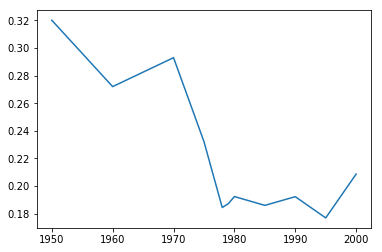

In [14]:
# Visually find the breakpoint with total MSE is at minimum
z = np.array(mse_pre) + np.array(mse_post)
plt.plot(T, z)

In [15]:
# Locate best breakpoint
tau_star = T[np.where(z == np.min(z))][0]
print(tau_star)

1995


In [16]:
# Piecewise linear regression with optimal tau
t_pre = t1[t1<=tau_star]
y_pre = y[t1<=tau_star]
robjs.globalenv['t_pre'] = robjs.FloatVector(t_pre)
robjs.globalenv['y_pre'] = robjs.FloatVector(y_pre)
fit_pre = r.lm('y_pre ~ t_pre')
k_hat_pre = fit_pre.rx2('coefficients')

t_post = t1[t1>=tau_star]
y_post = y[t1>=tau_star]
robjs.globalenv['t_post'] = robjs.FloatVector(t_post)
robjs.globalenv['y_post'] = robjs.FloatVector(y_post)
fit_post = r.lm('y_post ~ t_post')
k_hat_post = fit_post.rx2('coefficients')

In [17]:
t_hat_pre = k_hat_pre[0] + k_hat_pre[1]*t_pre
t_hat_post = k_hat_post[0] + k_hat_post[1]*t_post

In [20]:
def pieces(x, bp): 
    if x <= bp:
        return k_hat_pre[0] + k_hat_pre[1]*x
    else:
        return k_hat_post[0] + k_hat_post[1]*x

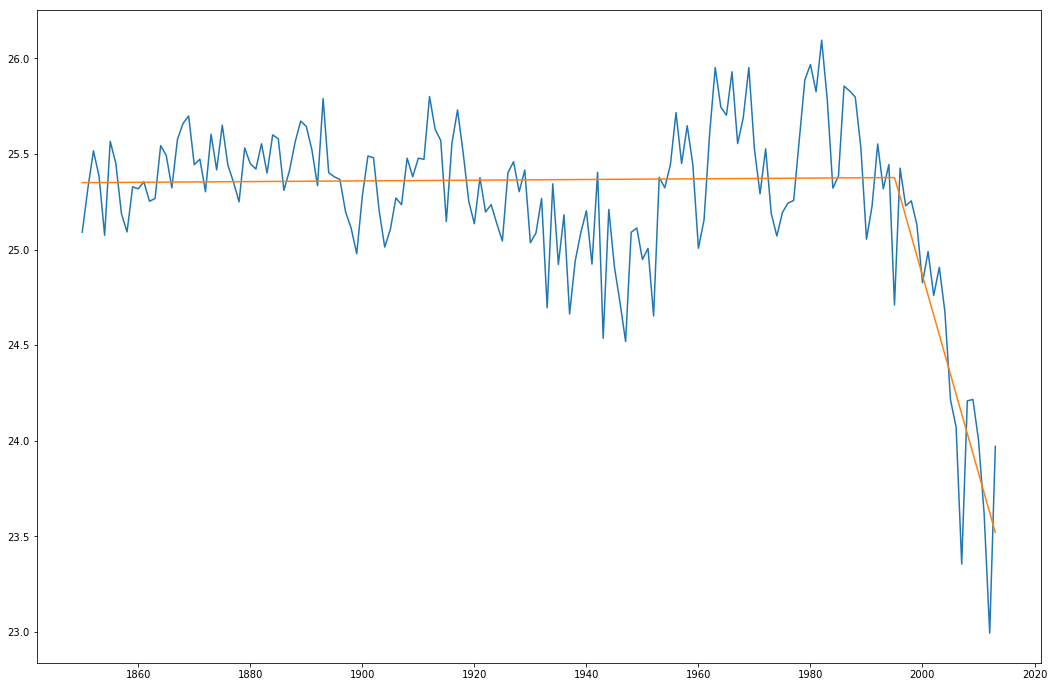

In [21]:
vpieces = np.vectorize(pieces)
y_piecewise = vpieces(t1, tau_star)

fig = plt.figure(figsize=(18, 12))
plt.plot(t1, y)
plt.plot(t1, y_piecewise)